# Data Mining Midterm Project
### Why We Chose This Dataset:
This data set is extremely robust with information that is thought to be linked to health and nutrition. There are extensive subsets such as demographics, diet, exams, labs, and more that can be analyzed to find correlations that contribute positively or negatively to overall health. There are a lot of questions that can be answered with this data set; we will try to focus on a few we think are interesting to us
### Business Questions:
1. Can we identify habits/factors that positively or negatively affect health?
2. Is there a correlation between income level and overall health?
3. Can we identify the main diseases that affect certain demographics?
4. Does the presence of one disease increase the likelihood of the presence of another diease within an individual?
### Project Outline:
1. **Software Engineering** - Will build functions such as `dataLoader(), logger(), featurize(), cluster(),` and `dimRed()` to streamline data transformations within the dataframe(s).
2. **Data Engineering** - Will clean, organize, and transform the data for ease of use during the research and analysis portion of the project. Featurization. 
3. **Business Analysis** - Discover initial challenge questions for the dataset(s). Then evolve the questions as we iterate through the project. 
4. **Research** - After featurization, extract metadata on the full dataset and run clustering/dimentions reduction on various slices of the data. Metadata will be added to each cluster. Each iteration may vary on addition/deletion of features as we attempts to gain a conclusion on our business questions. 
### Resources:
- https://www.kaggle.com/code/tobyanderson/health-survey-analysis
- https://www.kaggle.com/code/gopalkholade/diabetes-prediction
- https://www.kaggle.com/code/sohamohajeri/nhanes-dimensionality-reduction-and-clustering 
- https://www.kaggle.com/code/lcchennn/stroke-prediction-using-machine-learning
- https://www.kaggle.com/code/kaggleaar/diseases-and-medications-analysis

### TODO:
1. Featurize the dataset. Clean, organize, and transform the dataset into a useable format. Drop columns, fix null values, etc
2. Build functions `dataLoader(), logger(), cluster(), dimRed()`
3. Extract metadata, cluster, dimension reduction
4. Generate *great* visuals
5. Attempt to answer business questions. 

In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

**Useful Functions**

In [358]:
# Returns table with columns and corresponding null value percentages
def get_nulls(df):
    sum_null = df.isnull().sum()
    df_shape = df.shape[0]
    null = 100 * (sum_null / df_shape)
    return pd.DataFrame({'nullPercent': null})

# Selects colmuns with more than 70% null values and removes them from the df.
def null_handler(df):
    # get percentage of nulls in dataframe.
    df_null = get_nulls(df)
    high = df_null[df_null['nullPercent'] > 70]
    df.drop(list(high.index), axis=1, inplace=True)
    print("Dropped {} columns with more than 70% null values.".format(high.size))
    
# Selects columns with null values and replaces with the mean of each column
def mean_replace_null(df):
    df_null = get_nulls(df)
    df_maj_null = df_null[df_null['nullPercent'] > 0]
    for i in list(df_maj_null.index):
        df[i] = df[i].fillna(df[i].mean())
    print("Replaced {} columns with null values with mean of the column.".format(df_maj_null.size))

# Selects columns with object datatypes and removes them from the df. 
def object_handler(df):
    types = pd.DataFrame({'type': df.dtypes})
    objects = types[types['type'] == 'object']
    df.drop(list(objects.index), axis=1, inplace=True)
    print("Dropped {} columns with object data types".format(objects.size))

# reurns the number of null values in dataset
def check_nulls(df):
    sum_nulls = df.isna().sum().sum()

    print("Dataframe has {} null values".format(sum_nulls))

def corr_matrix(df, title):
    cmap = sns.color_palette("magma", as_cmap=True)
    fig = plt.figure(figsize=(10, 8))
    map = sns.heatmap(df.corr())
    plt.title(title,fontsize=15)
    labels=df.columns
    plt.show()

def expl_var_bargraph(dfx, n, title):
    sns.set(style='whitegrid')
    sns.set_color_codes('muted')

    pca = PCA(n_components=n)
    dfx_pca = pca.fit(dfx)

    length = len(dfx_pca.explained_variance_ratio_)

    x_vals = [i for i in range(length)]
    y_vals = pca.explained_variance_ratio_
    x_ticks = [i for i in range(0, len(dfx_pca.explained_variance_ratio_), 5)]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=x_vals,y=y_vals)
    plt.title("{}:\nExplained variance ratio of the \nfitted principal component vector\n".format(title), fontsize=25)
    
    plt.xlabel("Principal components",fontsize=15)
    plt.xticks(x_ticks,fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Explained variance ratio",fontsize=15)
    plt.show()
   

**Load and Join Data**

In [359]:
demo = pd.read_csv('nhnes/demographic.csv')
diet = pd.read_csv('nhnes/diet.csv')
exam = pd.read_csv('nhnes/examination.csv')
labs = pd.read_csv('nhnes/labs.csv')
meds = pd.read_csv('nhnes/medications.csv', encoding='latin1')

In [360]:
df = pd.concat([demo, diet, exam, labs], axis=1)
df = df.loc[:,~df.columns.duplicated()]
df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,URXUTL,URDUTLLC,URXUTU,URDUTULC,URXUUR,URDUURLC,URXPREG,URXUAS,LBDB12,LBDB12SI
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,524.0,386.7
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,507.0,374.2
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,732.0,540.2
3,73560,8,2,1,9,NaN,3,3,1.0,119.0,...,0.062,0.0,0.238,0.0,0.0071,0.0,NaN,3.83,NaN,NaN
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.0,166.1


In [361]:
df.iloc[:,1:].describe()

,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,URXUTL,URDUTLLC,URXUTU,URDUTULC,URXUUR,URDUURLC,URXPREG,URXUAS,LBDB12,LBDB12SI
count,10175.0,10175.000000,10175.000000,10175.000000,673.000000,10175.000000,10175.000000,9813.000000,4213.000000,6261.000000,...,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,1261.000000,2662.000000,5316.000000,5316.000000
mean,8.0,1.964423,1.508305,31.484128,10.341753,3.091892,3.289828,1.508509,107.478519,1.914071,...,0.186950,0.007883,0.150535,0.162162,0.012038,0.177177,1.969072,15.670639,640.100263,472.394865
std,0.0,0.185243,0.499956,24.421651,6.885479,1.263305,1.613241,0.499953,69.774776,0.288704,...,0.133833,0.088452,0.576409,0.368669,0.034026,0.381890,0.251651,46.735936,751.967084,554.951537
min,8.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.013000,0.000000,0.013000,0.000000,0.001400,0.000000,1.000000,0.280000,18.000000,13.300000
25%,8.0,2.000000,1.000000,10.000000,5.000000,2.000000,2.000000,1.000000,45.000000,2.000000,...,0.090000,0.000000,0.028000,0.000000,0.002600,0.000000,2.000000,3.210000,381.000000,281.200000
50%,8.0,2.000000,2.000000,26.000000,9.000000,3.000000,3.000000,2.000000,103.000000,2.000000,...,0.159000,0.000000,0.069000,0.000000,0.005100,0.000000,2.000000,6.240000,514.000000,379.300000
75%,8.0,2.000000,2.000000,52.000000,16.000000,4.000000,4.000000,2.000000,166.000000,2.000000,...,0.252000,0.000000,0.150000,0.000000,0.010700,0.000000,2.000000,12.435000,711.000000,524.700000
max,8.0,2.000000,2.000000,80.000000,24.000000,5.000000,7.000000,2.000000,239.000000,7.000000,...,1.290000,1.000000,25.760000,1.000000,0.843400,1.000000,3.000000,1071.300000,26801.000000,19779.100000


**Data Cleaning**
1. Keeping the columns that are not highly specific, repeated, or encoded in a way that is not meaningful to us
2. Handle nulls
3. Handle objects

In [362]:
col_decoder = {
'ACD011A' : 'speak_english',
'AIALANGA' : 'speak_english2',
'ALQ101' : 'drink_alcohol',
'ALQ130' : 'alcohol_per_day',
'AUQ136' : 'ear_infections',
'BMDAVSAD' : 'saggital_abdominal_avg',
'BMXARMC' : 'arm_circum',
'BMXBMI' : 'BMI',
'BMXLEG' : 'leg_length',
'BMXSAD1' : 'saggital_abdominal_1',
'BMXSAD2' : 'saggital_abdominal_2',
'BMXWAIST' : 'waist_circum',
'BMXWT' : 'weight_kg',
'BPQ020' : 'high_bp',
'BPQ056' : 'measure_bp_home',
'BPQ059' : 'measure_bp_doctor',
'BPQ060' : 'cholesterol_checked',
'BPQ070' : 'cholesterol_checked_1y',
'BPQ080' : 'high_cholesterol',
'BPQ090D' : 'cholesterol_prescription',
'BPXDI1' : 'diastolic_bp',
'BPXML1' : 'cuff_max_inflation',
'BPXSY1' : 'blood_pressure_1',
'BPXSY2' : 'blood_pressure_2',
'BPXSY3' : 'blood_pressure_3',
'CBD070' : 'grocery_budget',
'CBD090' : 'nonfood_budget',
'CBD110' : 'food_budget',
'CBD120' : 'restaurant_budget',
'CBD130' : 'food_delivery_budget',
'CBQ505' : 'fast_food',
'CBQ535' : 'saw_nutrition_fast_food',
'CBQ545' : 'use_nutrition_fast_food',
'CBQ550' : 'eat_restaurants',
'CBQ552' : 'eat_chain_restaurants',
'CBQ580' : 'saw_nutrition_restaurant',
'CBQ590' : 'use_nutrition_restaurant',
'CBQ596' : 'saw_my_plate',
'CDQ001' : 'chest_pain_ever',
'CDQ010' : 'short_breath_stairs',
'CSQ030' : 'sensative_smell',
'CSQ100' : 'loss_of_taste',
'CSQ110' : 'taste_in_mouth',
'CSQ202' : 'dry_mouth',
'CSQ204' : 'nasal_congestion',
'CSQ210' : 'wisdom_teeth_removed',
'CSQ220' : 'tonsils_removed',
'CSQ240' : 'head_injury',
'CSQ250' : 'broken_nose',
'CSQ260' : 'sinus_infections',
'DBD100' : 'salt_frequency',
'DBD895' : 'meals_not_homemade',
'DBD900' : 'meals_fast_food',
'DBD905' : 'meals_prepackaged',
'DBD910' : 'frozen_meals_per_month',
'DBQ095Z' : 'salt_type',
'DBQ197' : 'milk_product_per_month',
'DBQ229' : 'milk_drinker',
'DBQ700' : 'healthy_diet',
'DEQ034C' : 'long_sleeve_shirt',
'DEQ034D' : 'use_sunscreen',
'DEQ038G' : 'sunburn_1y',
'DIQ010' : 'diabetes',
'DIQ050' : 'taking_insulin',
'DIQ160' : 'prediabetes',
'DIQ170' : 'diabetes_risk',
'DIQ172' : 'diabetes_concern',
'DIQ180' : 'blood_test_3y',
'DLQ010' : 'deaf',
'DLQ020' : 'blind',
'DLQ040' : 'mental_issues',
'DLQ050' : 'difficulty_walking',
'DLQ060' : 'difficulty_dressing',
'DLQ080' : 'difficulty_errands',
'DMDBORN4' : 'born_in_us2',
'DMDHHSIZ' : 'people_in_house',
'DMDHHSZB' : 'children_in_house',
'DMDHHSZE' : 'people_over_60_in_house',
'DMDHRBR4' : 'born_in_us',
'DMDHRGND' : 'gender2',
'DMDMARTL' : 'Marital_Status',
'DMDYRSUS' : 'years_in_US',
'DPQ010' : 'no_interest_2w',
'DPQ020' : 'depression',
'DPQ030' : 'trouble_sleeping_2w',
'DPQ040' : 'fatigue_2w',
'DPQ050' : 'eating_problems_2w',
'DPQ060' : 'feel_bad_2w',
'DPQ070' : 'trouble_concentrating_2w',
'DPQ080' : 'speaking_problems_2w',
'DPQ090' : 'suicidal_2w',
'DPQ100' : 'depression_difficulty',
'DR1.320Z' : 'water',
'DR1_320Z' : 'plain_water_yesterday',
'DR1_330Z' : 'tap_water_yesterday',
'DR1BWATZ' : 'bottled_water_yesterday',
'DR1HELPD' : 'interview_help',
'DR1TACAR' : 'dietary_alpha_carotene',
'DR1TALCO' : 'alcohol',
'DR1TATOC' : 'dietary_vitamin_e',
'DR1TBCAR' : 'dietary_beta_carotene',
'DR1TCAFF' : 'caffeine',
'DR1TCALC' : 'dietary_calcium',
'DR1TCARB' : 'carb',
'DR1TCHL' : 'dietary_choline',
'DR1TCHOL' : 'cholesterol',
'DR1TCOPP' : 'dietary_copper',
'DR1TCRYP' : 'dietary_beta_cryptoxanthin',
'DR1TFA' : 'dietary_folic_acid',
'DR1TFF' : 'folate_food',
'DR1TFIBE' : 'fiber',
'DR1TFOLA' : 'dietary_folate',
'DR1TIRON' : 'dietary_iron',
'DR1TKCAL' : 'calories',
'DR1TLYCO' : 'dietary_lycopene',
'DR1TLZ' : 'dietary_lutein',
'DR1TM181' : 'octadecenoic_percent',
'DR1TMAGN' : 'magnesium',
'DR1TMFAT' : 'monounsaturated_fats',
'DR1TMOIS' : 'moisture',
'DR1TNIAC' : 'dietary_niacin',
'DR1TP183' : 'octadecatrienoic_percent',
'DR1TPHOS' : 'dietary_phosphorus',
'DR1TPOTA' : 'dietary_potassium',
'DR1TPROT' : 'protein',
'DR1TRET' : 'dietary_retinol',
'DR1TS140' : 'tetradeconoic_percent',
'DR1TSELE' : 'dietary_selenium',
'DR1TSODI' : 'sodium',
'DR1TSUGR' : 'sugar',
'DR1TTFAT' : 'fat',
'DR1TTHEO' : 'dietary_theobromine',
'DR1TVARA' : 'dietary_vitamin_a',
'DR1TVB1' : 'dietary_b1',
'DR1TVB12' : 'dietary_b12',
'DR1TVB2' : 'dietary_b2',
'DR1TVB6' : 'dietary_b6',
'DR1TVC' : 'dietary_vit_c',
'DR1TVD' : 'dietary_vit_d',
'DR1TVK' : 'dietary_vit_k',
'DR1TZINC' : 'dietary_zinc',
'DRABF' : 'breast_fed',
'DRQSPREP' : 'salt_used',
'DUQ200' : 'marijuana',
'DUQ370' : 'needle_drugs',
'FSD032A' : 'food_insecure',
'FSD032B' : 'not_enough_food',
'FSD032C' : 'cheap_food',
'FSD032D' : 'cheap_food_children',
'FSD032E' : 'bad_food_children',
'FSD032F' : 'low_food_children',
'FSD151' : 'emergency_food_received',
'FSDAD' : 'food_secure',
'FSDCH' : 'child_food_secure',
'FSDHH' : 'household_food_secure',
'FSQ162' : 'wic_received',
'FSQ165' : 'food_stamps',
'HEQ010' : 'hepetitis_b',
'HEQ030' : 'hepetitis_c',
'HIQ011' : 'health_insurance',
'HIQ210' : 'insurance_gap',
'HIQ270' : 'prescription_insurance',
'HOD050' : 'rooms_in_home',
'HOQ065' : 'homeowner',
'HSAQUEX' : 'health_status_source_data',
'HSD010' : 'general_health',
'HSQ500' : 'ever_had_cold',
'HSQ510' : 'intestinal_illness',
'HSQ520' : 'ever_had_flu',
'HSQ571' : 'donate_blood',
'HSQ590' : 'hiv',
'HUQ010' : 'general_health2',
'HUQ020' : 'health_compared_last_year',
'HUQ030' : 'routine_healthcare',
'HUQ041' : 'healthcare_location',
'HUQ051' : 'dr_visits',
'HUQ071' : 'overnight_hospital',
'HUQ090' : 'mental_health_treatment',
'IMQ011' : 'hepatitis_a_vaccine',
'IMQ020' : 'hepatitis_b_vaccine',
'IND235' : 'monthly_income',
'INDFMMPC' : 'poverty_level_category',
'INDFMMPI' : 'poverty_level_index',
'INDFMPIR' : 'family_income',
'INQ012' : 'self_employ_income',
'INQ020' : 'income_from_wages',
'INQ030' : 'income_from_SS',
'INQ060' : 'disability_income',
'INQ080' : 'retirement_income',
'INQ090' : 'ss_income',
'INQ132' : 'state_assistance_income',
'INQ140' : 'investment_income',
'INQ150' : 'other_income',
'INQ244' : 'family_savings',
'LBDBCDLC' : 'blood_cadmium',
'LBDBGMLC' : 'methyl_mercury',
'LBDHDD' : 'HDL_mg',
'LBDIHGLC' : 'inorganic_mercury',
'LBDNENO' : 'neutrophils_percent',
'LBDTHGLC' : 'blood_mercury',
'LBDWFL' : 'floride_water',
'LBXEOPCT' : 'eosinophils_percent',
'LBXGH' : 'glyco_hemoglobin',
'LBXLYPCT' : 'lymphocite_percent',
'LBXMC' : 'hemoglobin_concentration',
'LBXSAL' : 'blood_albumin',
'LBXSCA' : 'blood_calcium',
'LBXSGL' : 'serum_glucose_mg',
'LBXSTP' : 'blood_protein',
'MCQ010' : 'asthma_ever',
'MCQ025' : 'asthma_age',
'MCQ035' : 'asthma',
'MCQ040' : 'asthma_year',
'MCQ050' : 'asthma_ER',
'MCQ053' : 'anemia',
'MCQ070' : 'psoriasis',
'MCQ080' : 'overweight',
'MCQ082' : 'celiac_disease',
'MCQ086' : 'gluten_free',
'MCQ092' : 'blood_transfusion',
'MCQ149' : 'menstruate',
'MCQ151' : 'menstruate_age',
'MCQ160A' : 'arthritis',
'MCQ160B' : 'congestive_heart_failure',
'MCQ160C' : 'coronary_heart_disease',
'MCQ160D' : 'angina',
'MCQ160E' : 'heart_attack',
'MCQ160F' : 'stroke',
'MCQ160G' : 'emphysema',
'MCQ160K' : 'bronchitis_ever',
'MCQ160L' : 'liver_condition_ever',
'MCQ160M' : 'thyroid_ever',
'MCQ160N' : 'gout',
'MCQ160O' : 'COPD',
'MCQ170K' : 'bronchitis_now',
'MCQ170L' : 'liver_condition',
'MCQ170M' : 'thyroid_now',
'MCQ180A' : 'arthritis_age',
'MCQ180B' : 'heart_failure_age',
'MCQ180C' : 'heart_disease_age',
'MCQ180D' : 'angina_age',
'MCQ180E' : 'heart_attack_age',
'MCQ180F' : 'stroke_age',
'MCQ180G' : 'emphysema_age',
'MCQ180K' : 'bronchitis_age',
'MCQ180L' : 'liver_condition_age',
'MCQ180M' : 'thyroid_age',
'MCQ180N' : 'gout_age',
'MCQ195' : 'arthritis_type',
'MCQ203' : 'jaundice',
'MCQ206' : 'jaundice_age',
'MCQ220' : 'cancer',
'MCQ230A' : 'cancer_type1',
'MCQ230B' : 'cancer_type2',
'MCQ230C' : 'cancer_type3',
'MCQ230D' : 'cancer_type4',
'MCQ240A' : 'bladder_cancer_age',
'MCQ240AA' : 'test_cancer_age',
'MCQ240B' : 'blood_cancer_age',
'MCQ240BB' : 'thyroid_cancer_age',
'MCQ240C' : 'bone_cancer_age',
'MCQ240CC' : 'uterine_cancer_age',
'MCQ240D' : 'brain_cancer_age',
'MCQ240DK' : 'cancer_age',
'MCQ240E' : 'breast_cancer_age',
'MCQ240F' : 'cervical_cancer_age',
'MCQ240G' : 'colon_cancer_age',
'MCQ240H' : 'esoph_cancer_age',
'MCQ240I' : 'gallbladder_cancer_age',
'MCQ240J' : 'kidney_cancer_age',
'MCQ240K' : 'larynx_cancer_age',
'MCQ240L' : 'leukemia_age',
'MCQ240M' : 'liver_cancer_age',
'MCQ240N' : 'lung_cancer_age',
'MCQ240O' : 'lymphoma_age',
'MCQ240P' : 'melanoma_age',
'MCQ240Q' : 'mouth_cancer_age',
'MCQ240R' : 'nervous_cancer_age',
'MCQ240S' : 'ovarian_cancer_age',
'MCQ240T' : 'pancreatic_cancer_age',
'MCQ240U' : 'prostate_cancer_age',
'MCQ240V' : 'rectal_cancer_age',
'MCQ240X' : 'skin_cancer_age',
'MCQ240Y' : 'soft_cancer_age',
'MCQ240Z' : 'stomach_cancer_age',
'MCQ300A' : 'relative_heart_attack',
'MCQ300B' : 'relative_asthma',
'MCQ300C' : 'relative_diabetes',
'MCQ365A' : 'need_weight_loss',
'MCQ365B' : 'need_exercise',
'MCQ365C' : 'need_reduce_salt',
'MCQ365D' : 'need_reduce_calories',
'MCQ370A' : 'losing_weight',
'MCQ370B' : 'excercising',
'MCQ370C' : 'reducing_salt',
'MCQ370D' : 'reducing_fat',
'MGDCGSZ' : 'grip_strength',
'OCD150' : 'work_done',
'OCD270' : 'months_of_work',
'OCD390G' : 'type_of_work',
'OCD395' : 'job_duration',
'OCQ260' : 'non_govt_employee',
'OHQ030' : 'visit_dentist',
'OHQ033' : 'dentist_reason',
'OHQ620' : 'aching_mouth',
'OHQ640' : 'mouth_problems',
'OHQ680' : 'mouth_problems2',
'OHQ770' : 'need_dental',
'OHQ835' : 'gum_disease',
'OHQ845' : 'teeth_health',
'OHQ850' : 'gum_treatment',
'OHQ855' : 'loose_teeth',
'OHQ860' : 'teeth_bone_loss',
'OHQ865' : 'weird_tooth',
'OHQ870' : 'floss',
'OHQ875' : 'use_mouthwash',
'OHQ880' : 'oral_cancer_exam',
'OHQ885' : 'oral_cancer_exam2',
'OSQ060' : 'osteoporosis',
'OSQ130' : 'take_prednisone',
'OSQ230' : 'metal_objects',
'PAAQUEX' : 'question_source',
'PAD680' : 'sedentary_time',
'PAQ605' : 'vigorous_work',
'PAQ620' : 'moderate_work',
'PAQ635' : 'walk_or_bike',
'PAQ650' : 'vigorous_recreation',
'PAQ665' : 'moderate_recreation',
'PAQ710' : 'tv_hours',
'PAQ715' : 'pc_hours',
'PEASCST1' : 'bp_status',
'PEASCTM1' : 'blood_pressure_time',
'PFQ049' : 'work_limitations',
'PFQ051' : 'work_limitations2',
'PFQ054' : 'walk_equipment_required',
'PFQ057' : 'confusion_memory_problems',
'PFQ090' : 'special_healthcare_equipment',
'PUQ100' : 'insecticide_used',
'PUQ110' : 'weedkiller_used',
'RIAGENDR' : 'gender',
'RIDAGEYR' : 'age',
'RIDRETH1' : 'hispanic',
'RXQ510' : 'take_aspirin',
'SEQN' : 'id',
'SLD010H' : 'sleep_hours',
'SLQ050' : 'trouble_sleeping',
'SLQ060' : 'sleep_disorder',
'SMAQUEX.x' : 'question_mode',
'SMAQUEX.y' : 'question_mode2',
'SMAQUEX2' : 'question_mode3',
'SMD460' : 'smokers_in_house',
'SMDANY' : 'tobaco_1w',
'SMQ681' : 'smoked_1w',
'SMQ851' : 'tobaco2_1w',
'SMQ856' : 'smoked_at_work',
'SMQ858' : 'someone_smoked_at_job',
'SMQ860' : 'smoked_at_restaurant',
'SMQ863' : 'nicotine_1w',
'SMQ866' : 'smoked_at_bar',
'SMQ870' : 'smoked_in_car',
'SMQ872' : 'someone_smoked_in_car',
'SMQ874' : 'smoked_another_home',
'SMQ876' : 'someone_smoked_in_home',
'SMQ878' : 'smoked_other_building',
'SMQ880' : 'someone_smoked_other_building',
'SXD021' : 'sex_ever',
'URXUCR' : 'creatinine_urine',
'WHD010' : 'height_in',
'WHD020' : 'current_weight_lb',
'WHD050' : 'weight_1y',
'WHD110' : 'weight_10y',
'WHD120' : 'weight_age_25',
'WHD140' : 'greatest_weight',
'WHQ030' : 'overweight_self',
'WHQ040' : 'weightloss_desire',
'WHQ070' : 'weightloss_attempt',
'WHQ150' : 'age_when_heaviest'
}

keep_cols = list(col_decoder.values())

df = df.rename(columns = col_decoder)
demo = demo.rename(columns = col_decoder)
diet = diet.rename(columns = col_decoder)
exam = exam.rename(columns = col_decoder)
labs = labs.rename(columns = col_decoder)

df = df[df.columns.intersection(keep_cols)]
df

,id,gender,age,hispanic,born_in_us2,years_in_US,Marital_Status,speak_english2,people_in_house,children_in_house,...,neutrophils_percent,hemoglobin_concentration,creatinine_urine,floride_water,HDL_mg,glyco_hemoglobin,inorganic_mercury,methyl_mercury,blood_cadmium,blood_mercury
0,73557,1,69,4,1,NaN,4.0,1.0,3,0,...,2.0,33.4,NaN,NaN,65.0,13.9,NaN,NaN,NaN,NaN
1,73558,1,54,3,1,NaN,1.0,1.0,4,2,...,7.4,32.5,NaN,NaN,50.0,9.1,1.0,0.0,0.0,0.0
2,73559,1,72,3,1,NaN,1.0,NaN,2,0,...,4.9,34.3,NaN,NaN,60.0,8.9,0.0,0.0,0.0,0.0
3,73560,1,9,3,1,NaN,NaN,1.0,4,2,...,4.6,34.0,NaN,1.23,61.0,NaN,0.0,0.0,1.0,0.0
4,73561,2,73,3,1,NaN,1.0,NaN,2,0,...,4.5,33.0,NaN,NaN,85.0,4.9,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,83727,1,26,2,1,NaN,5.0,1.0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10171,83728,2,2,1,1,NaN,NaN,NaN,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10172,83729,2,42,4,2,6.0,3.0,NaN,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10173,83730,1,7,2,1,NaN,NaN,NaN,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [363]:
null_handler(df)
df.shape
object_handler(df)
df.shape
mean_replace_null(df)
check_nulls(df)


Dropped 2 columns with more than 70% null values.
Dropped 0 columns with object data types
Replaced 86 columns with null values with mean of the column.
Dataframe has 0 null values


In [364]:
keep = df.columns
demo_keep = demo.columns.intersection(keep)
diet_keep = diet.columns.intersection(keep)
exam_keep = exam.columns.intersection(keep)
labs_keep = labs.columns.intersection(keep)

demo = df[demo_keep]
diet = df[diet_keep]
exam = df[exam_keep]
labs = df[labs_keep]

In [365]:
check_nulls(demo)
check_nulls(diet)
check_nulls(exam)
check_nulls(labs)

Dataframe has 0 null values
Dataframe has 0 null values
Dataframe has 0 null values
Dataframe has 0 null values


In [366]:
df.iloc[:,1:].describe()

,gender,age,hispanic,born_in_us2,Marital_Status,speak_english2,people_in_house,children_in_house,people_over_60_in_house,gender2,...,eosinophils_percent,neutrophils_percent,hemoglobin_concentration,floride_water,HDL_mg,glyco_hemoglobin,inorganic_mercury,methyl_mercury,blood_cadmium,blood_mercury
count,10175.000000,10175.000000,10175.000000,10175.000000,10175.000000,10175.000000,10175.000000,10175.000000,10175.000000,10175.000000,...,10175.000000,10175.000000,10175.000000,10175.000000,10175.000000,10175.000000,10175.000000,10175.000000,10175.000000,10175.000000
mean,1.508305,31.484128,3.091892,1.227027,2.571850,1.099414,3.874693,1.008354,0.396560,1.499951,...,2.987710,4.094788,33.809890,0.561246,53.105194,5.642556,0.826087,0.255072,0.289933,0.256759
std,0.499956,24.421651,1.263305,1.830533,1.977475,0.264461,1.722184,1.193006,0.704731,0.500025,...,2.232832,1.631504,0.948589,0.227003,13.183809,0.811904,0.270326,0.310884,0.324848,0.312759
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.400000,28.000000,0.010000,10.000000,3.500000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,10.000000,2.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,...,1.700000,3.100000,33.400000,0.561246,45.000000,5.300000,0.826087,0.000000,0.000000,0.000000
50%,2.000000,26.000000,3.000000,1.000000,2.571850,1.000000,4.000000,1.000000,0.000000,1.000000,...,2.800000,4.094788,33.809890,0.561246,53.105194,5.642556,0.826087,0.255072,0.289933,0.256759
75%,2.000000,52.000000,4.000000,1.000000,2.571850,1.099414,5.000000,2.000000,1.000000,2.000000,...,3.400000,4.700000,34.300000,0.561246,57.000000,5.642556,1.000000,0.255072,0.289933,0.256759
max,2.000000,80.000000,5.000000,99.000000,99.000000,3.000000,7.000000,4.000000,3.000000,2.000000,...,36.600000,25.600000,69.600000,7.320000,173.000000,17.500000,1.000000,1.000000,1.000000,1.000000


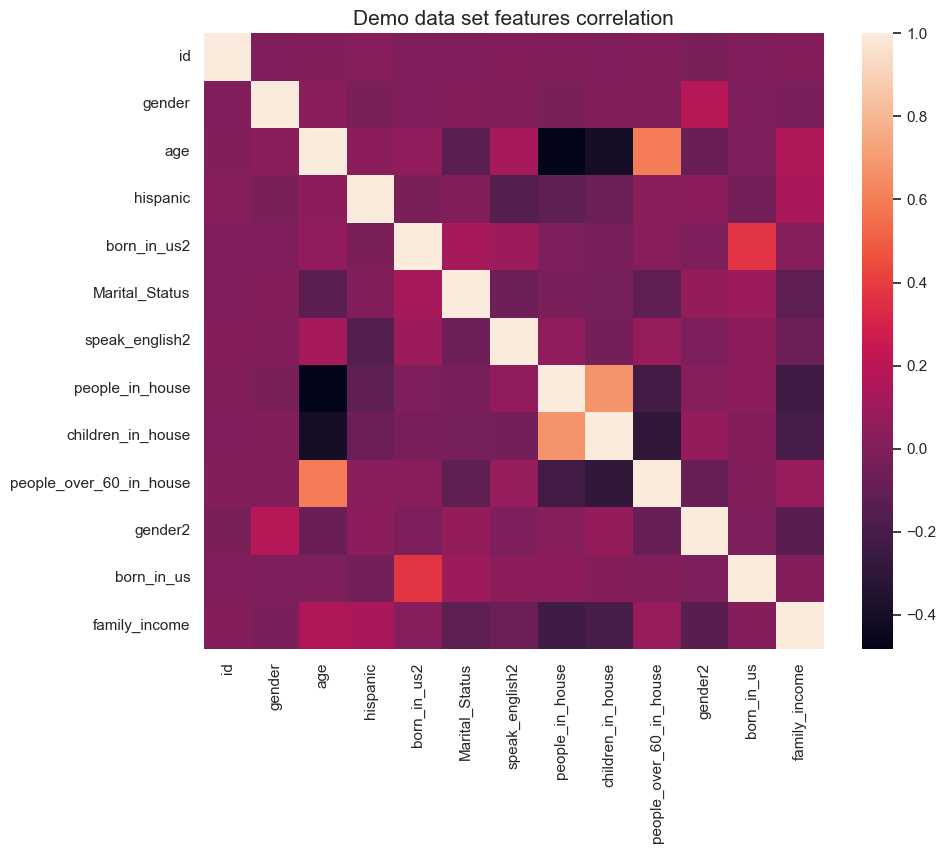

In [367]:
#demo, diet, exam, labs
corr_matrix(demo, 'Demo data set features correlation')


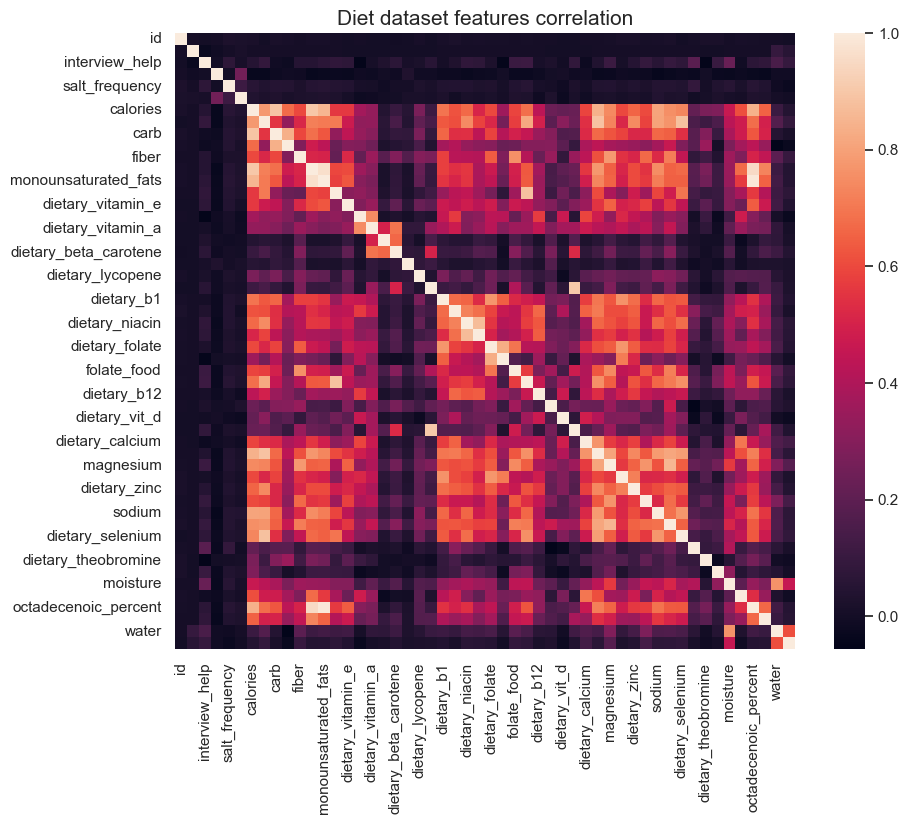

In [368]:
corr_matrix(diet, 'Diet dataset features correlation')


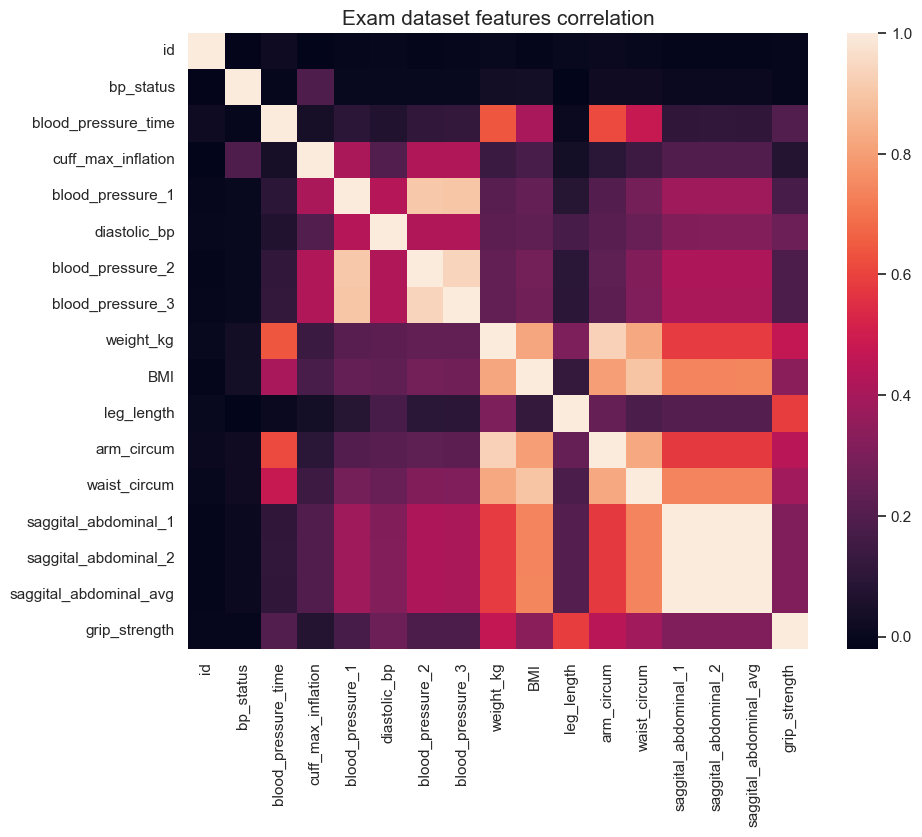

In [369]:
corr_matrix(exam, 'Exam dataset features correlation')


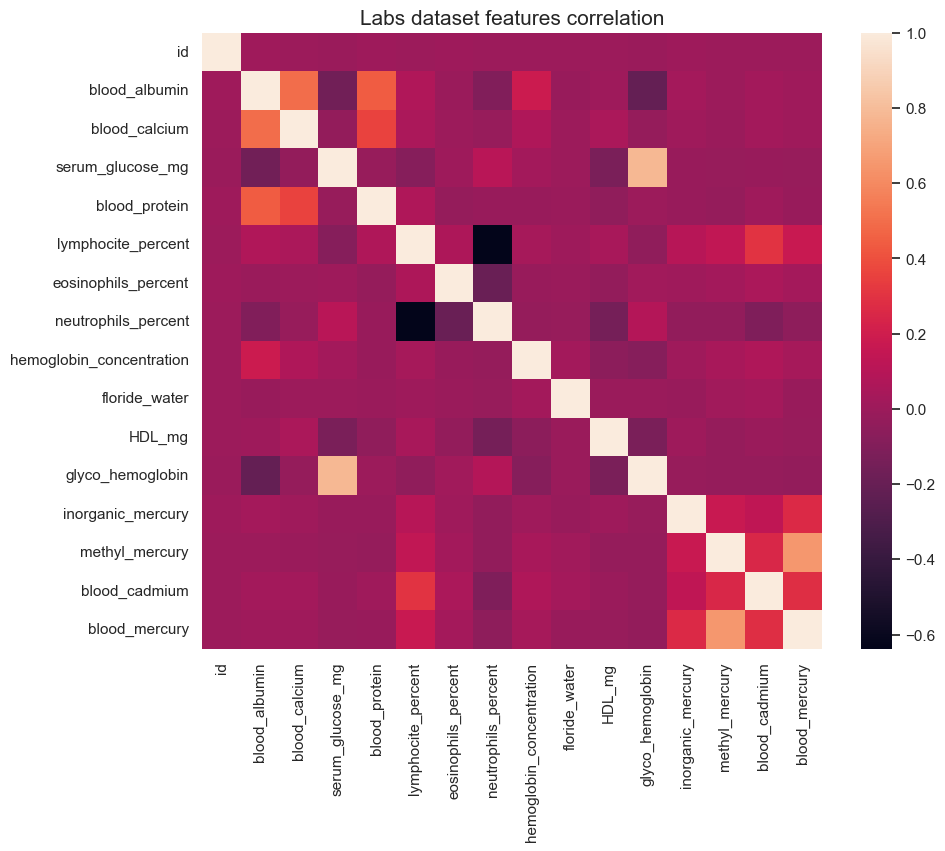

In [370]:
corr_matrix(labs, 'Labs dataset features correlation')

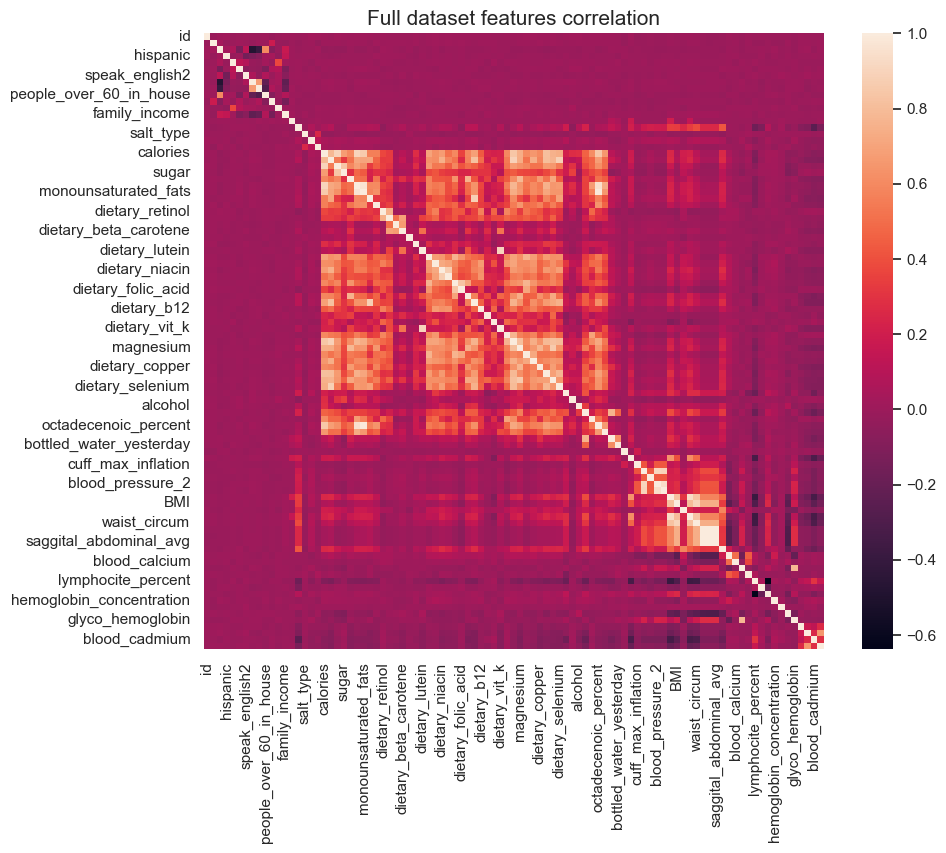

In [371]:
corr_matrix(df, 'Full dataset features correlation')

The Diet and Exam datasets look promising.